# Velocity Bcs

In [1]:
#load in parent stuff
#%load_ext autoreload
import nb_load_stuff
from tectModelClass import *

importing Jupyter notebook from tectModelClass.ipynb


In [2]:
#If run through Docker we'll point at the local 'unsupported dir.'
#On hpc, the path should also include a directory holding the unsupported_dan.
import os
import sys

if os.getcwd() == '/workspace/newSlab':
    sys.path.append('../unsupported')

#this does't actually need to be protected. More a reminder it's an interim measure
try:
    sys.path.append('../unsupported')
except:
    pass

In [3]:
#%load_ext autoreload

from unsupported_dan.UWsubduction.base_params import *
from unsupported_dan.UWsubduction.subduction_utils import *
from unsupported_dan.interfaces.marker2D import markerLine2D, line_collection
from unsupported_dan.interfaces.smoothing2D import *

../unsupported/unsupported_dan/interfaces/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """


In [4]:
ndp.maxDepth

0.05172413793103448

In [5]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
from easydict import EasyDict as edict
import networkx as nx
import operator




## Changes to base params

In [6]:
#These will keep changing if the notebook is run again without restarting!

ndp.depth *= 0.8 #800 km
ndp.faultThickness *= 1.5 #15 km
ndp.interfaceViscCutoffDepth *= 1.5 #150 km
ndp.maxDepth *= 1.5
md.res = 64
ndp.radiusOfCurv*=0.72  #~250 km
md.nltol = 0.025
md.ppc = 25
#print(ndp.faultThickness*2900)
ndp.yieldStressMax *=0.5  #150 Mpa

## Build mesh, Stokes Variables

In [7]:
#(ndp.rightLim - ndp.leftLim)/ndp.depth
#md.res = 64

In [8]:
yres = int(md.res)
xres = int(md.res*12) 

mesh = uw.mesh.FeMesh_Cartesian( elementType = (md.elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = (ndp.leftLim, 1. - ndp.depth), 
                                 maxCoord    = (ndp.rightLim, 1.)) 

velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2)
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )


velocityField.data[:] = 0.
pressureField.data[:] = 0.

## Build plate model

In [9]:
#Set up some velocities
cm2ms = (1/100.)*(1./(3600*24*365)) 

vp1= 0.*cm2ms #m/s
vp1 /= sf.velocity

vp2= 3.*cm2ms #m/s
vp2 /= sf.velocity

vp3= -2.*cm2ms #m/s
vp3 /= sf.velocity

vb12= 0.5*cm2ms #m/s
vb12 /= sf.velocity

ma2s = 1e6*(3600*24*365)
endTime = 30*ma2s/sf.time
dt = 0.1*ma2s/sf.time
testTime = 5*ma2s/sf.time


In [10]:
#print(vp1, vp2, vp3, vb12)

In [11]:
#20 Ma moddel, timestep of 200 Ka 
tg = TectModel(mesh, 0, endTime, dt)

#tg.add_plate(1, velocities=vp1)
tg.add_plate(2, velocities=vp2)
tg.add_plate(3, velocities=vp3)

In [12]:
#tg.add_left_boundary(1, plateInitAge=ndp.slabMaxAge/3., velocities=False)
tg.add_left_boundary(2, plateInitAge=0., velocities=False)

#tg.add_ridge(1,2, -0.6, velocities=vb12)
tg.add_subzone(2, 3, 0.2, subInitAge=ndp.slabMaxAge, upperInitAge=ndp.opMaxAge)

tg.add_right_boundary(3, plateInitAge=0.0, velocities=False)

## Build plate age

In [13]:
pIdFn = tg.plate_id_fn()
pAgeDict = tg.plate_age_fn() 

fnAge_map = fn.branching.map(fn_key = pIdFn , 
                          mapping = pAgeDict )

#fig = glucifer.Figure(figsize=(600, 300))
#fig.append( glucifer.objects.Surface(tg.mesh, fnAge_map ))
#fig.show()

In [14]:
coordinate = fn.input()
depthFn = mesh.maxCoord[1] - coordinate[1]
plateTempProxFn = ndp.potentialTemp*fn.math.erf((depthFn)/(2.*fn.math.sqrt(1.*fnAge_map)))

In [15]:
#fig = glucifer.Figure(figsize=(600, 300))
#fig.append( glucifer.objects.Surface(tg.mesh, pIdFn))
#fig.show()

## Make swarm and Slabs

In [16]:
def circGradientFn(S):
    if S == 0.:
        return 0.
    elif S < ndp.radiusOfCurv:
        return max(-S/np.sqrt((ndp.radiusOfCurv**2 - S**2)), -1e3)
    else:
        return -1e5

In [17]:
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
layout = uw.swarm.layouts.PerCellRandomLayout(swarm=swarm, particlesPerCell=int(md.ppc))
swarm.populate_using_layout( layout=layout ) # Now use it to populate.
proxyTempVariable = swarm.add_variable( dataType="double", count=1 )
proximityVariable      = swarm.add_variable( dataType="int", count=1 )
signedDistanceVariable = swarm.add_variable( dataType="double", count=1 )

#
proxyTempVariable.data[:] = 1.0
proximityVariable.data[:] = 0.0
signedDistanceVariable.data[:] = 0.0


In [18]:
#All of these wil be needed by the slab / fault setup functions
#We have two main options, bind them to the TectModel class. 
#or provide them to the functions
#collection them in a dictionary may be a useful way too proviede them to the function 
#wthout blowing out the function arguments

tmUwMap = tm_uw_map([], velocityField, swarm, 
                    signedDistanceVariable, proxyTempVariable, proximityVariable)




In [19]:
#define fault particle spacing, here ~5 paricles per element
ds = (tg.maxX - tg.minX)/(2.*tg.mesh.elementRes[0])

fCollection = line_collection([])




for e in tg.undirected.edges():
    if tg.is_subduction_boundary(e):
        build_slab_distance(tg, e, circGradientFn, ndp.maxDepth, tmUwMap)        
        fb = build_fault(tg, e, circGradientFn, ndp.faultThickness , ndp.maxDepth, ds, ndp.faultThickness, tmUwMap)
        fCollection.append(fb)

#
build_slab_temp(tmUwMap, ndp.potentialTemp, ndp.slabMaxAge)
fnJointTemp = fn.misc.min(proxyTempVariable,plateTempProxFn)

#And now reevaluate this guy on the swarm
proxyTempVariable.data[:] = fnJointTemp.evaluate(swarm)


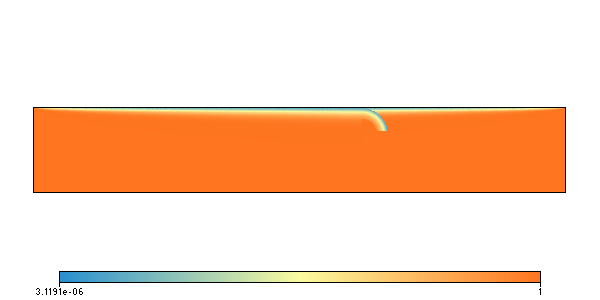

In [20]:
#fig = glucifer.Figure(figsize=(600, 300))
#fig.append( glucifer.objects.Points(swarm, proxyTempVariable))
    

#fig.show()
#fig.save_database('test.gldb')

##  Fault rebuild

In [21]:
# Setup a swarm to define the replacment positions

fThick= fCollection[0].thickness

faultloc = 1. - ndp.faultThickness*md.faultLocFac

allxs = np.arange(mesh.minCoord[0], mesh.maxCoord[0], ds )[:-1]
allys = (mesh.maxCoord[1] - fThick)*np.ones(allxs.shape)

faultMasterSwarm = uw.swarm.Swarm( mesh=mesh )
dummy =  faultMasterSwarm.add_particles_with_coordinates(np.column_stack((allxs, allys)))
del allxs
del allys

The combination of surface kinematic boundary conditions and faults requires more specialised mask functions. 

In [24]:
#this one will repopulating (overpopulate) the faults
boundMaskFn = tg.plate_interior_mask_fn(relativeWidth=0.75, 
                                        minPlateLength=10e3/sf.lengthScale, invert=False)

#this one will truncate the faults
#ridgeMaskFn = tg.variable_boundary_mask_fn(distMax=100., distMin=0.0, relativeWidth = 0.85, 
#                                  minPlateLength =50e3/sf.lengthScale,  
#                                           out = 'bool', boundtypes='ridge', bound=(1,2))


#this one will truncate the faults
ridgeMaskFn = tg.variable_boundary_mask_fn(distMax=100., distMin=0.0, relativeWidth = 0.85, 
                                  minPlateLength =50e3/sf.lengthScale,  
                                           out = 'bool', boundtypes='ridge', bound=(2,2))


###The following mask function provide a way of building velocity conditions within the plates,
#while leaving nodes near the plate boundaries free to adjust

#this one is intended as a the velocity mask function
velMask1 = tg.variable_boundary_mask_fn(distMax=20.2, distMin=0.0, relativeWidth = 0.85, 
                        minPlateLength =50e3/sf.lengthScale,  out = 'bool', boundtypes='ridge')

#this one will repopulating (overpopulate) the faults
velMask2= tg.plate_interior_mask_fn(relativeWidth=0.95, 
                                        minPlateLength=10e3/sf.lengthScale, invert=False)

velMaskFn = operator.and_( velMask1,  velMask2)

dummy = remove_fault_drift(fCollection, faultloc)
dummy = pop_or_perish(tg, fCollection, faultMasterSwarm, boundMaskFn, ds)
dummy = remove_faults_from_boundaries(fCollection, ridgeMaskFn)


(0.9027586206896553, 0.9027586206896553)
(0.9027586206896553, 0.9027586206896553)
(0.5627586206896551, 0.5627586206896551)



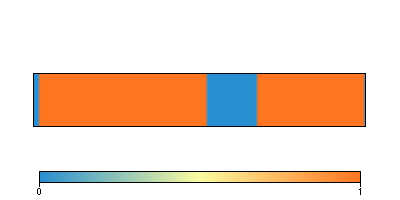

In [33]:
fig = glucifer.Figure(figsize=(400, 200))
#fig.append( glucifer.objects.Surface(tg.mesh, pIdFn, valueRange=[0,3]))
fig.append( glucifer.objects.Surface(tg.mesh, velMaskFn))
#fig.append( glucifer.objects.Surface(tg.mesh, testFn))


#for f in fCollection:
#    fig.append( glucifer.objects.Points(f.swarm, pointSize=5))
fig.show()

#fig.save_database('test.gldb')

In [26]:
#testFn = tg.t2f(boundMaskFn1)

#testFn = tg.f2b( tg.b2f(boundMaskFn1))

In [27]:
#testFn.evaluate(mesh)

## Proximity



In [28]:
proximityVariable.data[:] = 0

In [29]:
for f in fCollection:
    f.rebuild()
    f.set_proximity_director(swarm, proximityVariable, searchFac = 2., locFac=1.0)


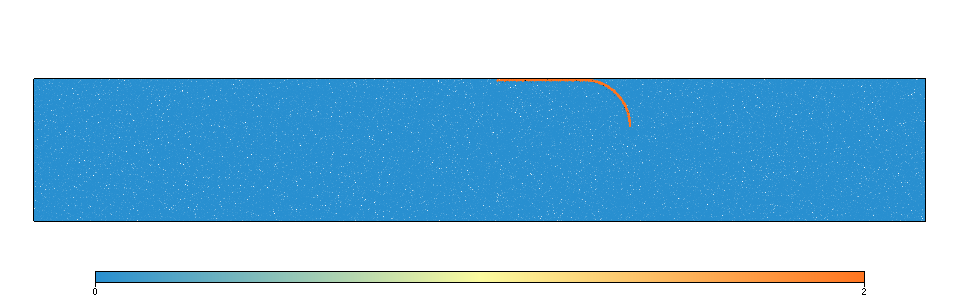

In [30]:
#figProx = glucifer.Figure(figsize=(960,300) )
#figProx.append( glucifer.objects.Points(swarm , proximityVariable))
#for f in fCollection:
#    figProx.append( glucifer.objects.Points(f.swarm, pointSize=5))
#figProx.show()

## Prescribed velocity

In [31]:
def set_vel_return_nodes(time, maskFn):
    """
    globals:
    velocityField
    """
    
    nodes = tg.plate_vel_node_fn(time, maskFn = maskFn)
    
    pIdFn = tg.plate_id_fn()
    velMapFn = tg.plateVelFn(testTime, pIdFn)
    locs = tg.mesh.data[nodes]
    
    #Now set the veolcity on the nodes
    velocityField.data[nodes, 0] = velMapFn.evaluate(locs)[:,0]
    
    return nodes
    

In [32]:
vXnodes = set_vel_return_nodes(0., velMaskFn)

In [33]:
#set_vel_return_nodes?

In [70]:
#check
#%pylab inline
#tWalls = tg.mesh.specialSets['MaxJ_VertexSet']


#fig, ax = plt.subplots(figsize=(10, 2))
#plt.plot(mesh.data[tWalls.data][:,0], velocityField.data[tWalls.data][:,0])#
#plt.scatter(mesh.data[vXnodes ][:,0], np.zeros(len(mesh.data[vXnodes ][:,0])), s = 0.5, c = 'k')
#ax.hlines(500, tg.minX, tg.maxX, linestyles='--')

## Boundary conditions

In [71]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls = mesh.specialSets["MinJ_VertexSet"]


#velBC  = uw.conditions.DirichletCondition( variable        = velocityField, 
#                                           indexSetsPerDof = (iWalls, jWalls) )


In [72]:
#vXnodes

In [73]:
def build_velBcs(nodes):
    
    velnodeset = mesh.specialSets["Empty"]
    velnodeset += nodes
    
    
    
    velBC  = uw.conditions.DirichletCondition( variable        = velocityField, 
                                           indexSetsPerDof = (iWalls + velnodeset, jWalls - velnodeset) )
    
    return velBC

In [74]:
velBC = build_velBcs(vXnodes)

In [77]:
#vXnodes

## Bouyancy

In [75]:
# Now create a buoyancy force vector using the density and the vertical unit vector. 
thermalDensityFn = ndp.rayleigh*(1. - proxyTempVariable)

gravity = ( 0.0, -1.0 )

buoyancyMapFn = thermalDensityFn*gravity

## Rheology

In [37]:
symStrainrate = fn.tensor.symmetric( 
                            velocityField.fn_gradient )

#Set up any functions required by the rheology
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))



def safe_visc(func, viscmin=ndp.viscosityMin, viscmax=ndp.viscosityMax):
    return fn.misc.max(viscmin, fn.misc.min(viscmax, func))

In [38]:
temperatureFn = proxyTempVariable
adiabaticCorrectFn = depthFn*ndp.tempGradMantle
dynamicPressureProxyDepthFn = pressureField/sf.pressureDepthGrad
druckerDepthFn = fn.misc.max(0.0, depthFn + md.druckerAlpha*(dynamicPressureProxyDepthFn))

#Diffusion Creep
diffusionUM = (1./ndp.diffusionPreExp)*\
            fn.math.exp( ((ndp.diffusionEnergy + (depthFn*ndp.diffusionVolume))/((temperatureFn+ adiabaticCorrectFn + ndp.surfaceTemp))))

diffusionUM =     safe_visc(diffusionUM)
    
diffusionLM = ndp.lowerMantleViscFac*(1./ndp.lowerMantlePreExp)*\
            fn.math.exp( ((ndp.lowerMantleEnergy + (depthFn*ndp.lowerMantleVolume))/((temperatureFn+ adiabaticCorrectFn + ndp.surfaceTemp))))

diffusionLM =     safe_visc(diffusionLM)

    
#combine upper and lower mantle   
mantleCreep = fn.branching.conditional( ((depthFn < ndp.lowerMantleDepth, diffusionUM ), 
                                           (True,                      diffusionLM )  ))

#Define the mantle Plasticity
ys =  ndp.cohesionMantle + (druckerDepthFn*ndp.frictionMantle)
ysf = fn.misc.min(ys, ndp.yieldStressMax)
yielding = ysf/(2.*(strainRate_2ndInvariant) + 1e-15) 


mantleRheologyFn = safe_visc(fn.misc.min(mantleCreep, yielding), viscmin=ndp.viscosityMin, viscmax=ndp.viscosityMax)

#Subduction interface viscosity
interfaceViscosityFn = fn.misc.constant(0.5)

In [39]:
#viscconds = ((proximityVariable == 0, mantleRheologyFn),
#             (True, interfaceViscosityFn ))

#viscosityMapFn = fn.branching.conditional(viscconds)
#viscosityMapFn = mantleRheologyFn


viscosityMapFn = fn.branching.map( fn_key = proximityVariable,
                             mapping = {0:mantleRheologyFn,
                                        2:interfaceViscosityFn} )

## Stokes

In [40]:
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=tWalls)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=tWalls)

NodePressure = uw.mesh.MeshVariable(mesh, nodeDofCount=1)
Cell2Nodes = uw.utils.MeshVariable_Projection(NodePressure, pressureField, type=0)
Nodes2Cell = uw.utils.MeshVariable_Projection(pressureField, NodePressure, type=0)

def smooth_pressure(mesh):
    # Smooths the pressure field.
    # Assuming that pressure lies on the submesh, do a cell -> nodes -> cell
    # projection.

    Cell2Nodes.solve()
    Nodes2Cell.solve()

# a callback function to calibrate the pressure - will pass to solver later
def pressure_calibrate():
    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate()
    offset = p0/area
    pressureField.data[:] -= offset
    smooth_pressure(mesh)

In [41]:
stokes = uw.systems.Stokes( velocityField  = velocityField, 
                                   pressureField  = pressureField,
                                   conditions     = [velBC,],
                                   fn_viscosity   = viscosityMapFn, 
                                   fn_bodyforce   = buoyancyMapFn )


In [42]:
solver = uw.systems.Solver(stokes)

solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4


In [43]:
solver.solve(nonLinearIterate=True, nonLinearTolerance=md.nltol, callback_post_solve = pressure_calibrate)
solver.print_stats()


 
Pressure iterations:   3
Velocity iterations:   1 (presolve)      
Velocity iterations:  -1 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   1 (total solve)   
 
SCR RHS  solve time: 6.5290e-01
Pressure solve time: 5.6569e-02
Velocity solve time: 6.5653e-01 (backsolve)
Total solve time   : 1.4803e+00
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 



## Swarm Advector

In [44]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )


In [45]:
population_control = uw.swarm.PopulationControl(swarm, deleteThreshold=0.006, 
                                                splitThreshold=0.25,maxDeletions=1, maxSplits=3, aggressive=True,
                                                aggressiveThreshold=0.9, particlesPerCell=int(md.ppc))

## Update functions

In [46]:
# Here we'll handle everything that should be advected - i.e. every timestep
def advect_update():
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    # Advect swarm
    advector.integrate(dt)
    
    #Advect faults
    for f in fCollection:
        f.advection(dt)
    
    
    return dt, time+dt, step+1

In [47]:
def update_stokes(time):
    
    #rebuild the velocity mask Fn
    
    velMask1 = tg.variable_boundary_mask_fn(distMax=20.2, distMin=0.0, relativeWidth = 0.75, 
                            minPlateLength =50e3/sf.lengthScale,  out = 'bool', boundtypes='ridge')

    velMask2= tg.plate_interior_mask_fn(relativeWidth=0.95, 
                                            minPlateLength=10e3/sf.lengthScale, invert=False)

    velMaskFn = operator.and_( velMask1,  velMask2)
    
    #set velocity back to zero
    velocityField.data[:] = 0.
    
    #set the new surface vel, get the velXNodes
    vXnodes = set_vel_return_nodes(time, velMaskFn)
    
    #creata a BC object
    velBC = build_velBcs(vXnodes)
    
    
    
    #rebuild stokes
    stokes = uw.systems.Stokes( velocityField  = velocityField, 
                                   pressureField  = pressureField,
                                   conditions     = [velBC,],
                                   fn_viscosity   = viscosityMapFn, 
                                   fn_bodyforce   = buoyancyMapFn )
    return stokes

In [48]:
def rebuild_solver(stokes):
    
    solver = uw.systems.Solver(stokes)
    solver.set_inner_method("mumps")
    solver.options.scr.ksp_type="cg"
    solver.set_penalty(1.0e7)
    solver.options.scr.ksp_rtol = 1.0e-4
    
    return solver


In [49]:
def update_faults():
    
    ##the mask fns are static at this stage
    #ridgeMaskFn = tg.ridge_mask_fn(ridgedist)
    #subMaskFn = tg.subduction_mask_fn(subdist)
    #boundMaskFn = tg.combine_mask_fn(ridgeMaskFn , subMaskFn )
    
    
    dummy = remove_faults_from_boundaries(fCollection, ridgeMaskFn)
    dummy = remove_fault_drift(fCollection, faultloc, tolFac =ds*2)
    dummy = pop_or_perish(tg, fCollection, faultMasterSwarm, boundMaskFn, ds*3)
    
    for f in fCollection:
        
        #Remove particles below a specified depth
        depthMask = f.swarm.particleCoordinates.data[:,1] < \
        (1. - (ndp.interfaceViscCutoffDepth - ndp.faultThickness))
        with f.swarm.deform_swarm():
            f.swarm.particleCoordinates.data[depthMask] = (9999999., 9999999.)
        
        #Here we're grabbing a 'black box' routine , 
        #which is supposed to maintain particle density and smooth
        #quite experimental!!!
        repair_markerLines(f, ds, k=8)
    

In [50]:
def update_swarm():
    
    population_control.repopulate()
    
    for f in fCollection:
        f.rebuild()
        f.set_proximity_director(swarm, proximityVariable, searchFac = 2., locFac=1.0,
                                maxDistanceFn=fn.misc.constant(2.))
        
    #A simple depth cutoff for proximity
    depthMask = swarm.particleCoordinates.data[:,1] < (1. - ndp.interfaceViscCutoffDepth)
    proximityVariable.data[depthMask] = 0
    
    
    
    
    

In [50]:
outputPath = os.path.join(os.path.abspath("."),"output/files")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()


surfacexs = mesh.data[tWalls.data][:,0]
surfaceys = mesh.data[tWalls.data][:,1]
surfLine = markerLine2D(mesh, velocityField,surfacexs, surfaceys , 0,  99)
surfVx = uw.swarm.SwarmVariable(surfLine.swarm, 'double', 1)

def save_files(step):
    surfVx.data[:] = velocityField[0].evaluate(surfLine.swarm)
    
    surfVx.save( "output/files/surfVx_" + str(step).zfill(3) + "_.h5")

In [51]:
#save_files(0)

In [51]:
#e = (3,3)
#time = 1e-5
#for e in tg.undirected.edges():
#    print(tg.bound_has_vel(e, time))

In [63]:
def set_boundary_vel_update(tectModel, platePair, time, dt):
    bv = 0.
    try:
        bv = tectModel.bound_velocity(platePair, time=time)
    except:
        pass
    
    dx = bv*dt
    newx = (tectModel.get_bound_loc(platePair) + dx)
    
    return newx


def strain_rate_field_update(tectModel, e, tmUwMap):
    dist = 100e3/sf.lengthScale #limit the search radius
    maskFn = tectModel.plate_boundary_mask_fn(dist, out='num',bound=e )
    srLocMins, srLocMaxs = strain_rate_min_max(tectModel, tmUwMap, maskFn)
    if tg.is_subduction_boundary(e):
        return srLocMins[0][1]
    else:
        return srLocMaxs[0][1]
    

def update_tect_model(tectModel, tmUwMap, time, dt = 0.0 ):
    
    """
    An example of how we can update the tect_model
    """
    for e in tectModel.undirected.edges():
        
        #This is generally the first condition to check" a specified boundary velocity
        if tectModel.bound_has_vel(e, time):
            newX = set_boundary_vel_update(tectModel, e, time, dt)
            tectModel.set_bound_loc(e, newX)
            
        #in this model the ficticious boundaries remain fixed at the edge
        elif e[0] == e[1]:
            pass       
        #now we'll apply a strain rate query to update the subduction zone loc
        elif tectModel.is_subduction_boundary(e):
            e = tectModel.subduction_edge_order(e)
            newx = strain_rate_field_update(tectModel, e, tmUwMap)
            tectModel.set_bound_loc(e, newx)
        else:
            pass
        
        
def rebuild_mask_fns():
    
    
    #this one will repopulating (overpopulate) the faults
    boundMaskFn = tg.plate_interior_mask_fn(relativeWidth=0.75, 
                                            minPlateLength=10e3/sf.lengthScale, invert=False)

    #this one will truncate the faults
    #ridgeMaskFn = tg.variable_boundary_mask_fn(distMax=100., distMin=0.0, relativeWidth = 0.75, 
    #                                  minPlateLength =50e3/sf.lengthScale,  
    #                                           out = 'bool', boundtypes='ridge', bound=(1,2))
     
    ridgeMaskFn = tg.variable_boundary_mask_fn(distMax=100., distMin=0.0, relativeWidth = 0.75, 
                                      minPlateLength =50e3/sf.lengthScale,  
                                               out = 'bool', boundtypes='ridge', bound=(2,2))
       
    return ridgeMaskFn, boundMaskFn

In [64]:
#ridgeMaskFn, subMaskFn, boundMaskFn = rebuild_mask_fns()

In [65]:
#st = update_stokes(0)
#svt = rebuild_solver(st)

In [67]:
#dttest = advector.get_max_dt()
#update_tect_model(tg, tmUwMap,time=0., dt = dttest)

In [68]:
#f.data.shape

In [69]:
#update_faults()
#update_swarm()

## Track the values of the plate bounaries

In [70]:
valuesDict = edict({})
valuesDict.timeAtSave = []
valuesDict.stepAtSave = []
for e in tg.undirected.edges():
    valuesDict[str(e)] = []
valuesDict    

{'(1, 1)': [],
 '(1, 2)': [],
 '(2, 3)': [],
 '(3, 3)': [],
 'stepAtSave': [],
 'timeAtSave': []}

In [56]:
def valuesUpdateFn():
    
    """ 
    Assumes global variables:
    * time
    * step 
    ...
    + many functions
    """
    
    
    #save the time and step
    valuesDict.timeAtSave.append(time) 
    valuesDict.stepAtSave.append(step)
    
    for e in tg.undirected.edges():
        if tg.is_subduction_boundary(e):
            ee = tg.subduction_edge_order(e) #hacky workaround for the directed/ undireted. need get_bound_loc
        else:
            ee = e

        valuesDict[str(e)].append(tg.get_bound_loc(ee))
        
        
    #save
    if uw.rank()==0:
        fullpath = os.path.join(outputPath + "tect_model_data")
        #the '**' is important
        np.savez(fullpath, **valuesDict)
    

In [57]:
#valuesUpdateFn()
#valuesDict  
#!ls output

## Viz

In [92]:
outputPath = os.path.join(os.path.abspath("."),"output/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

In [93]:
store1 = glucifer.Store('output/subduction1')
store2 = glucifer.Store('output/subduction2')
#store3 = glucifer.Store('output/subduction3')


figProx = glucifer.Figure(store1, figsize=(960,300) )
figProx.append( glucifer.objects.Points(swarm , proximityVariable))
for f in fCollection:
    figProx.append( glucifer.objects.Points(f.swarm, pointSize=5))
#figProx.show()

figVisc = glucifer.Figure( store2, figsize=(960,300) )
figVisc.append( glucifer.objects.Points(swarm, viscosityMapFn, pointSize=2, logScale=True) )



#figMask = glucifer.Figure( store3, figsize=(960,300) )
#figMask.append( glucifer.objects.Surface(mesh, pIdFn , valueRange=[0,3]) )
#figMask.append( glucifer.objects.Surface(mesh,  boundMaskFn) )




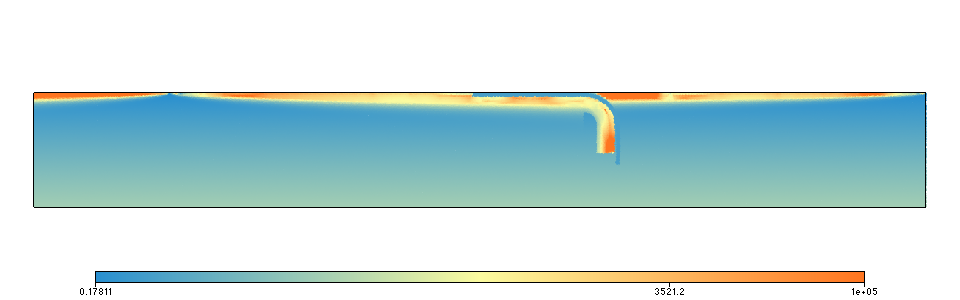

In [94]:
#figVisc.show()
#figProx.save_database('test.gldb')

In [44]:
#1e-2*2900.

## Main Loop

In [132]:
time = 0.  # Initial time
step = 0 
maxSteps = 2000      # Maximum timesteps (201 is recommended)
steps_output = 5   # output every 10 timesteps
swarm_update = 5   # output every 10 timesteps
faults_update = 10
dt_model = 0.
steps_update_model = 10

valuesUpdateFn()

In [47]:
#while time < tg.times[-1]:
while step < maxSteps:
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True)
    
    #advect swarm and faults
    dt, time, step =  advect_update()
    dt_model += dt
    
    
    #running fault healing/addition, map back to swarm
    if step % faults_update == 0:
        update_faults()
    if step % swarm_update == 0:
        update_swarm()
        
    #update tectonic model
    if step % steps_update_model == 0:
        update_tect_model(tg, tmUwMap, time, dt = dt_model)
        dt_model = 0.
        #ridgeMaskFn, subMaskFn, boundMaskFn, pIdFn= rebuild_mask_fns()
        
        ridgeMaskFn, boundMaskFn = rebuild_mask_fns()
        valuesUpdateFn()
        
    #rebuild stokes
    if step % steps_update_model == 0:
        del solver
        del stokes
        stokes = update_stokes(time)
        solver = rebuild_solver(stokes)
        
    
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        #Important to set the timestep for the store object here or will overwrite previous step
        store1.step = step
        store2.step = step
        #store3.step = step
        figProx.save(    outputPath + "proximity"    + str(step).zfill(4))
        figVisc.save(    outputPath + "visc"    + str(step).zfill(4))
        #figMask.save(    outputPath + "mask"    + str(step).zfill(4))
        
        #save out the surface velocity
        save_files(step)
    
    if uw.rank()==0:
        print 'step = {0:6d}; time = {1:.3e}'.format(step,time)


step =      1; time = 8.138e-06
step =      2; time = 1.593e-05
step =      3; time = 2.334e-05
step =      4; time = 3.055e-05
step =      5; time = 3.749e-05
step =      6; time = 4.409e-05
step =      7; time = 5.039e-05
step =      8; time = 5.649e-05
step =      9; time = 6.228e-05
step =     10; time = 6.781e-05
step =     11; time = 7.324e-05
step =     12; time = 7.850e-05
step =     13; time = 8.339e-05
step =     14; time = 8.796e-05
step =     15; time = 9.223e-05
step =     16; time = 9.622e-05
step =     17; time = 1.000e-04
step =     18; time = 1.036e-04
step =     19; time = 1.070e-04
step =     20; time = 1.103e-04
